In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MNRE
from criterions import WeightedLoss, RELoss, RDLoss
from samplers import TractableSampler, NRESampler
from histograms import pairhist, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([-1.4199, -2.1682,  0.3081,  0.2356, -2.6175], device='cuda:0'),
 tensor([[-1.3756, -2.1821],
         [-1.5017, -2.1143],
         [-1.4710, -2.1356],
         [-1.5404, -2.0965]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator)

## Model

In [7]:
joint_subsets = torch.tensor([
    [False, False, False, True, True],
    [False, False, True, True, True],
    [True, True, True, True, True]
])

joint_subsets

tensor([[False, False, False,  True,  True],
        [False, False,  True,  True,  True],
        [ True,  True,  True,  True,  True]])

In [8]:
model = MNRE(masks=joint_subsets, encoder=Flatten((4, 2)), num_layers=10, hidden_size=512, activation=nn.SELU).to(device)
criterion = RELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

### Train

In [9]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, xs)
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

torch.save(model.state_dict(), 'mnre.pth')

0: 2.0632247924804688 +- 0.46234017610549927
1: 1.7033222913742065 +- 0.29829734563827515
2: 1.6248681545257568 +- 0.9592339396476746
3: 1.9149938821792603 +- 1.541005253791809
4: 1.8262099027633667 +- 1.4397467374801636
5: 1.6978254318237305 +- 1.2689905166625977
6: 1.6053617000579834 +- 1.1458038091659546
7: 1.4985661506652832 +- 1.008129596710205
8: 1.2712761163711548 +- 0.6439196467399597
9: 1.128254771232605 +- 0.3385270833969116
10: 1.0372272729873657 +- 0.1653045117855072
11: 1.0046331882476807 +- 0.1560506522655487
12: 0.9813151359558105 +- 0.11589478701353073
13: 0.9712719917297363 +- 0.13331589102745056
14: 0.9122797846794128 +- 0.0873696357011795
15: 0.9020655155181885 +- 0.06382111459970474
16: 0.8795382976531982 +- 0.08323206007480621
17: 0.8622305393218994 +- 0.12223856151103973
18: 0.849608302116394 +- 0.1129513755440712
19: 0.8498923182487488 +- 0.11530134826898575
20: 0.8425955772399902 +- 0.15777526795864105
21: 0.8351289629936218 +- 0.20573820173740387
22: 0.82624876

In [10]:
# model.load_state_dict(torch.load('mnre.pth', map_location=device))

## Metropolis-Hastings

In [11]:
low = simulator.low.cpu()
high = simulator.high.cpu()

In [12]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

In [13]:
x_star = x_star.expand(2 ** 12, -1, -1)

### MNRE

In [14]:
model.eval()
z_star = model.encoder(x_star)

#### 4 & 5

In [15]:
mask, nre = model[0]
mask = mask.cpu()

In [16]:
labels = [f'$\\theta_{{{i}}}$' for i in [4, 5]]

In [17]:
sampler = NRESampler(simulator.subprior(mask), nre, z_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low[mask], high[mask], bins=60, normed=True, bounded=True)

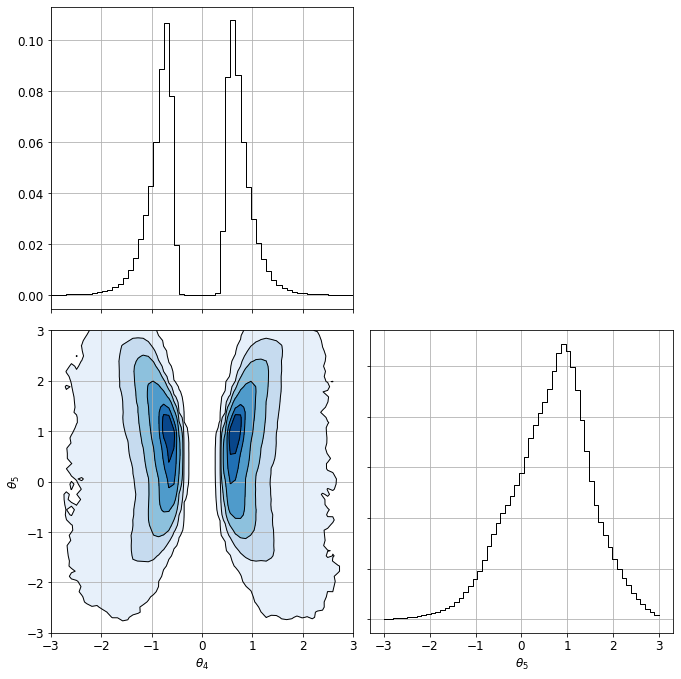

In [18]:
fig = corner(hists, low[mask], high[mask], labels=labels)

#### 3, 4 & 5

In [19]:
mask, nre = model[1]
mask = mask.cpu()

In [20]:
labels = [f'$\\theta_{{{i}}}$' for i in [3, 4, 5]]

In [21]:
sampler = NRESampler(simulator.subprior(mask), nre, z_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low[mask], high[mask], bins=60, normed=True, bounded=True)

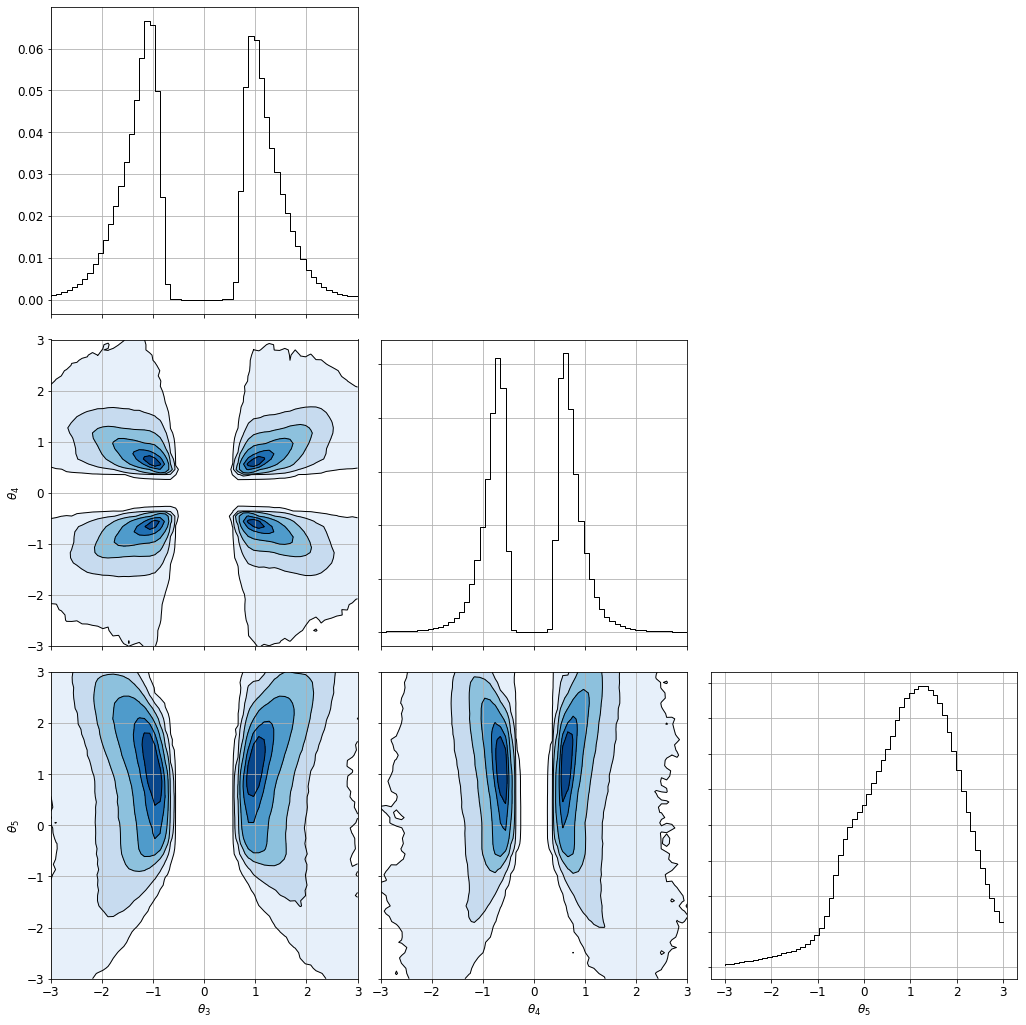

In [22]:
fig = corner(hists, low[mask], high[mask], labels=labels)

#### All

In [23]:
_, nre = model[2]

In [24]:
labels = [f'$\\theta_{{{i}}}$' for i in [1, 2, 3, 4, 5]]

In [25]:
sampler = NRESampler(simulator.prior, nre, z_star, sigma=0.1)
samples = sampler(4096)
hists = pairhist(samples, low, high, bins=60, normed=True, bounded=True)

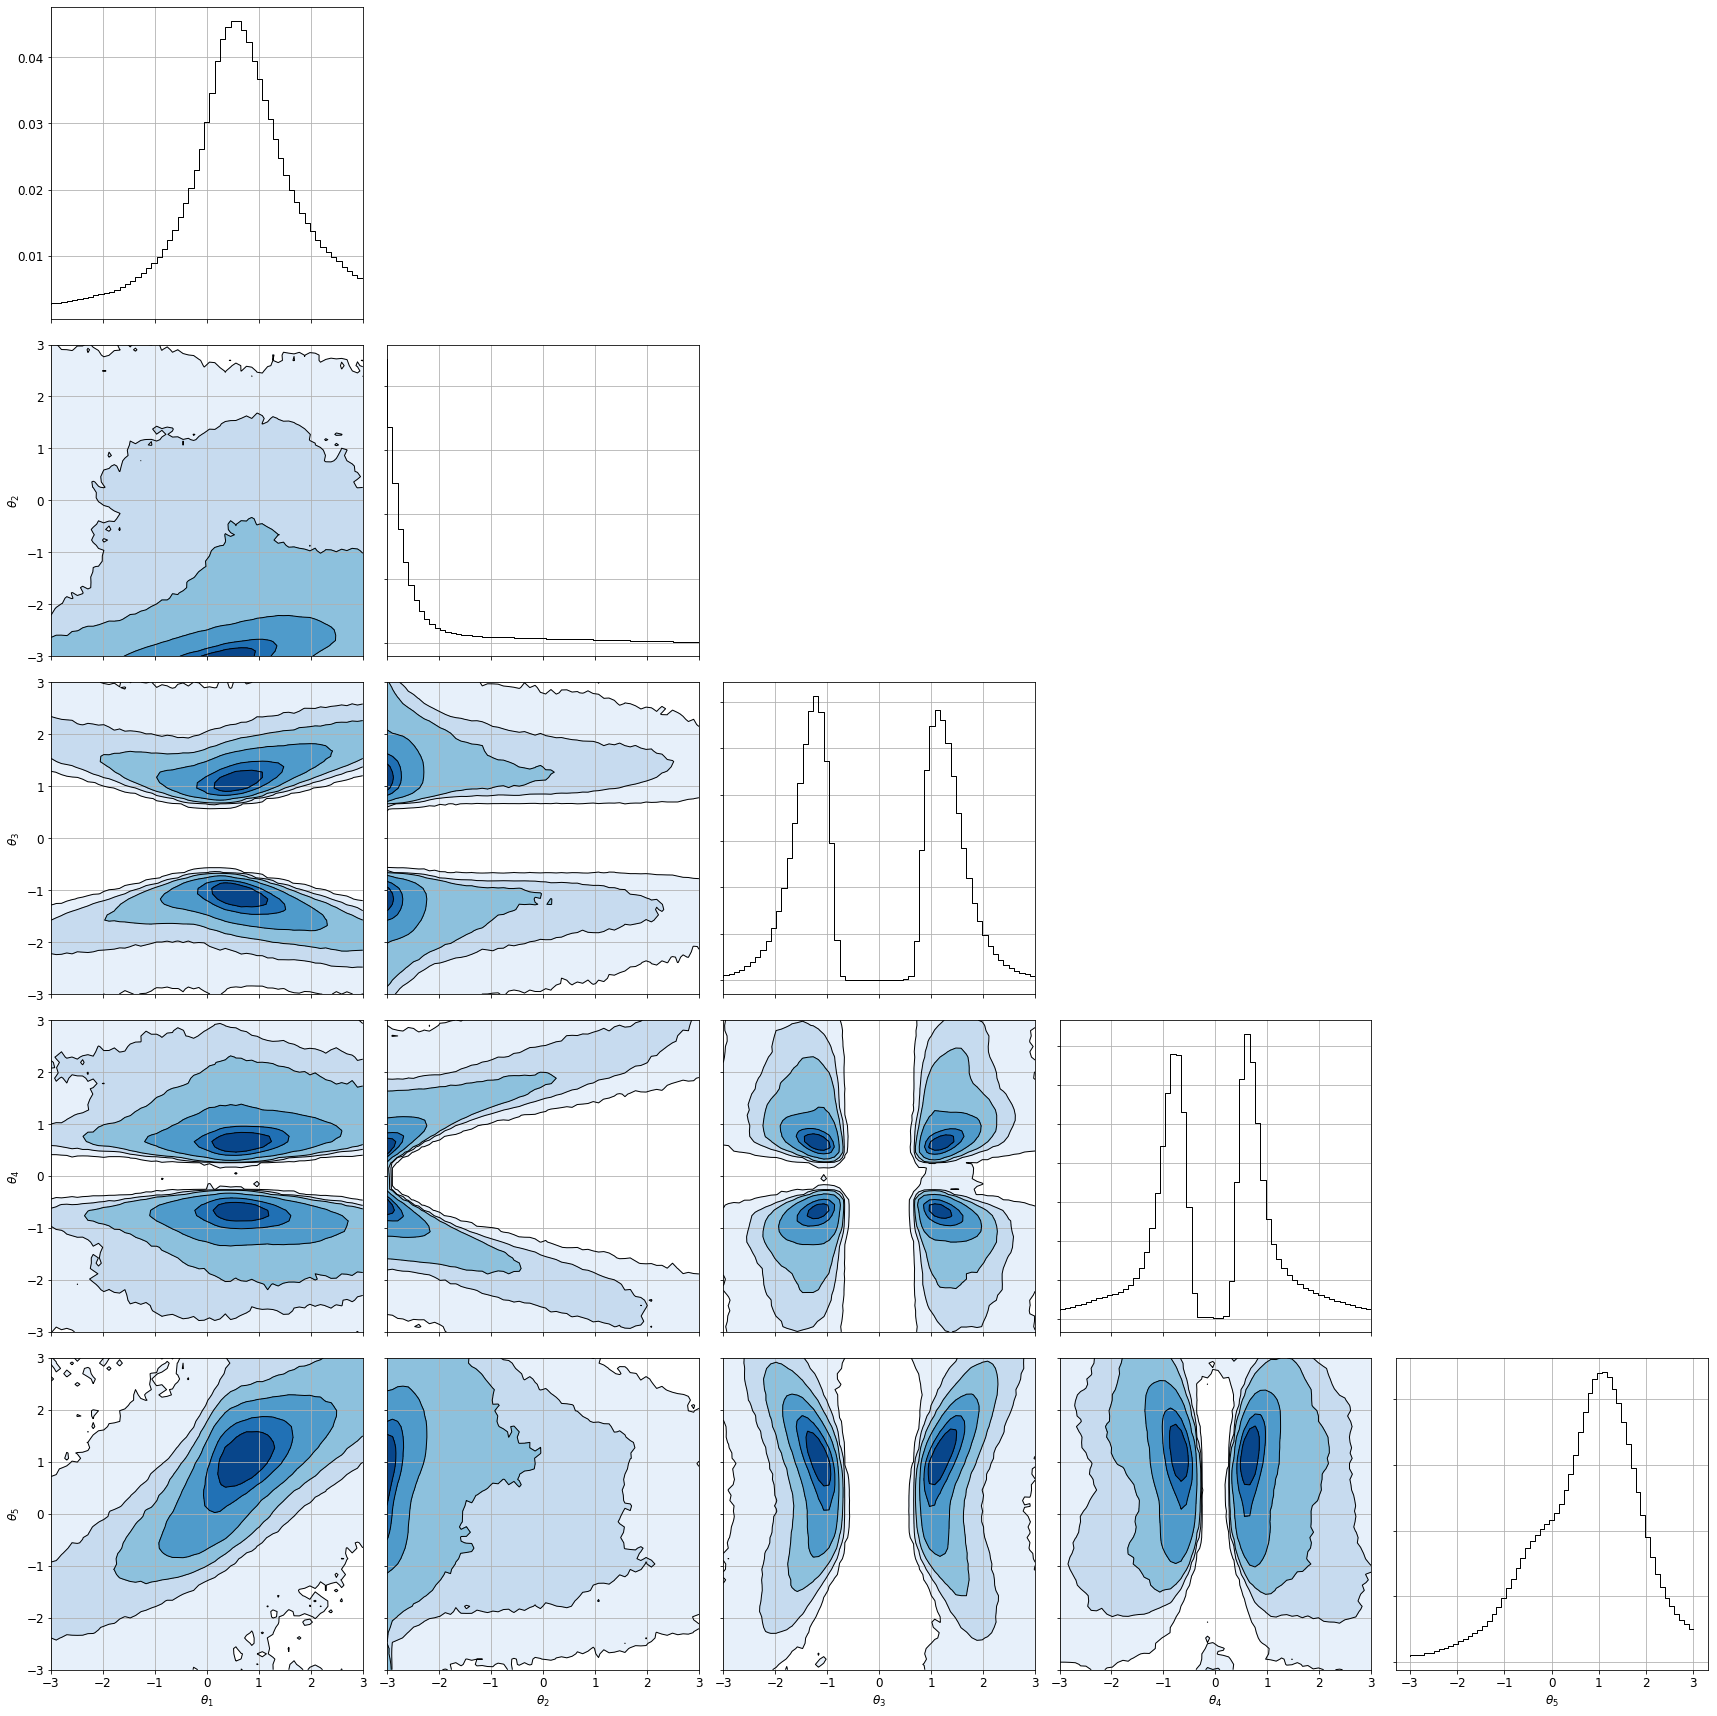

In [26]:
fig = corner(hists, low, high, labels=labels)